In [1]:
#https://github.com/likejazz/jupyter-notebooks/tree/master/deep-learning/keras-attention
#>> https://github.com/datalogue/keras-attention.git

!git clone https://github.com/jukyellow/keras-attention.git

Cloning into 'keras-attention'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 154 (delta 4), reused 0 (delta 0), pack-reused 143
Receiving objects: 100% (154/154), 15.63 MiB | 7.43 MiB/s, done.
Resolving deltas: 100% (60/60), done.


In [2]:
!pip install Faker

     |████████████████████████████████| 901kB 2.8MB/s 


In [3]:
import random
import json
import os

#DATA_FOLDER = os.path.realpath(os.path.join(os.path.realpath(__file__), '..'))
DATA_FOLDER = os.path.realpath(os.path.join(os.path.abspath(''), '..'))
print('DATA_FOLDER:', DATA_FOLDER)
DATA_FOLDER = '/content/keras-attention/data'
print('DATA_FOLDER:', DATA_FOLDER)


from faker import Faker
import babel
from babel.dates import format_date

fake = Faker()
fake.seed(230517)
random.seed(230517)

FORMATS = ['short',
           'medium',
           'long',
           'full',
           'd MMM YYY',
           'd MMMM YYY',
           'dd MMM YYY',
           'd MMM, YYY',
           'd MMMM, YYY',
           'dd, MMM YYY',
           'd MM YY',
           'd MMMM YYY',
           'MMMM d YYY',
           'MMMM d, YYY',
           'dd.MM.YY',
           ]

# change this if you want it to work with only a single language
# LOCALES = ['en_US']
LOCALES = babel.localedata.locale_identifiers()


def create_date():
    """
        Creates some fake dates 
        :returns: tuple containing 
                  1. human formatted string
                  2. machine formatted string
                  3. date object.
    """
    dt = fake.date_object()

    # wrapping this in a try catch because
    # the locale 'vo' and format 'full' will fail
    try:
        human = format_date(dt,
                            format=random.choice(FORMATS),
                            locale=random.choice(LOCALES))

        case_change = random.randint(0,3) # 1/2 chance of case change
        if case_change == 1:
            human = human.upper()
        elif case_change == 2:
            human = human.lower()

        machine = dt.isoformat()
    except AttributeError as e:
        # print(e)
        return None, None, None

    return human, machine, dt


def create_dataset(dataset_name, n_examples, vocabulary=False):
    """
        Creates a csv dataset with n_examples and optional vocabulary
        :param dataset_name: name of the file to save as
        :n_examples: the number of examples to generate
        :vocabulary: if true, will also save the vocabulary
    """
    human_vocab = set()
    machine_vocab = set()

    with open(dataset_name, 'w') as f:
        for i in range(n_examples):
            h, m, _ = create_date()
            if h is not None:
                f.write('"'+h + '","' + m + '"\n')
                human_vocab.update(tuple(h))
                machine_vocab.update(tuple(m))
            if(i==0):
                print('create_dataset h:',h,',m:',m,',_:',_)

    if vocabulary:
        int2human = dict(enumerate(human_vocab))
        int2human.update({len(int2human): '<unk>',
                          len(int2human)+1: '<eot>'})
        int2machine = dict(enumerate(machine_vocab))
        int2machine.update({len(int2machine):'<unk>',
                            len(int2machine)+1:'<eot>'})

        human2int = {v: k for k, v in int2human.items()}
        machine2int = {v: k for k, v in int2machine.items()}

        with open(os.path.join(DATA_FOLDER, 'human_vocab.json'), 'w') as f:
            json.dump(human2int, f)
        with open(os.path.join(DATA_FOLDER, 'machine_vocab.json'), 'w') as f:
            json.dump(machine2int, f)

DATA_FOLDER: /
DATA_FOLDER: /content/keras-attention/data


In [4]:
if __name__ == '__main__':
    print('creating dataset')
    create_dataset(os.path.join(DATA_FOLDER, 'training.csv'), 50000,
                   vocabulary=True)
    create_dataset(os.path.join(DATA_FOLDER, 'validation.csv'), 100)
    print('dataset created.')

creating dataset
create_dataset h: 12, sept. 2010 ,m: 2010-09-12 ,_: 2010-09-12
create_dataset h: 18 mar. 1990 ,m: 1990-03-18 ,_: 1990-03-18
dataset created.


In [5]:
"""
    Runs a simple Neural Machine Translation model
    Type `python run.py -h` for help with arguments.
"""
import os
import argparse

from keras.callbacks import ModelCheckpoint

#from models.NMT import simpleNMT
#from data.reader import Data, Vocabulary
#from utils.metrics import all_acc
#from utils.examples import run_examples


Using TensorFlow backend.


In [0]:
import keras.backend as K

def all_acc(y_true, y_pred):
    """
        All Accuracy
        https://github.com/rasmusbergpalm/normalization/blob/master/train.py#L10
    """
    return K.mean(
        K.all(
            K.equal(
                K.max(y_true, axis=-1),
                K.cast(K.argmax(y_pred, axis=-1), K.floatx())
            ),
            axis=1)
    )

In [0]:
import json
import csv
import random

import numpy as np
from keras.utils.np_utils import to_categorical

random.seed(1984)

INPUT_PADDING = 50
OUTPUT_PADDING = 100


class Vocabulary(object):

    def __init__(self, vocabulary_file, padding=None):
        """
            Creates a vocabulary from a file
            :param vocabulary_file: the path to the vocabulary
        """
        print('vocabulary_file:', vocabulary_file)
        self.vocabulary_file = vocabulary_file
        with open(vocabulary_file, 'r') as f:
            self.vocabulary = json.load(f)

        self.padding = padding
        self.reverse_vocabulary = {v: k for k, v in self.vocabulary.items()}

    def size(self):
        """
            Gets the size of the vocabulary
        """
        #print('Vocabulary.size: ', self.vocabulary.keys())
        return len(self.vocabulary.keys())

    def string_to_int(self, text):
        """
            Converts a string into it's character integer 
            representation
            :param text: text to convert
        """
        characters = list(text)

        integers = []

        if self.padding and len(characters) >= self.padding:
            # truncate if too long
            characters = characters[:self.padding - 1]

        characters.append('<eot>')

        for c in characters:
            if c in self.vocabulary:
                integers.append(self.vocabulary[c])
            else:
                integers.append(self.vocabulary['<unk>'])


        # pad:
        if self.padding and len(integers) < self.padding:
            integers.extend([self.vocabulary['<unk>']]
                            * (self.padding - len(integers)))

        if len(integers) != self.padding:
            print(text)
            raise AttributeError('Length of text was not padding.')
        #print('Vocabulary.string_to_int: ', len(integers))
        return integers

    def int_to_string(self, integers):
        """
            Decodes a list of integers
            into it's string representation
        """
        characters = []
        for i in integers:
            characters.append(self.reverse_vocabulary[i])
        #print('Vocabulary.int_to_string: ', len(characters))
        return characters


class Data(object):

    def __init__(self, file_name, input_vocabulary, output_vocabulary):
        """
            Creates an object that gets data from a file
            :param file_name: name of the file to read from
            :param vocabulary: the Vocabulary object to use
            :param batch_size: the number of datapoints to return
            :param padding: the amount of padding to apply to 
                            a short string
        """

        self.input_vocabulary = input_vocabulary
        self.output_vocabulary = output_vocabulary
        self.file_name = file_name

    def load(self):
        """
            Loads data from a file
        """
        self.inputs = []
        self.targets = []

        with open(self.file_name, 'r') as f:
            reader = csv.reader(f)
            for row in reader:
                self.inputs.append(row[0])
                self.targets.append(row[1])

        print('Data.load len(inputs): ', len(self.inputs))
        print('Data.load len(targets): ', len(self.targets))
        print('Data.load (inputs[0]): ', self.inputs[0])
        print('Data.load (targets[0]): ', self.targets[0])

    def transform(self):
        """
            Transforms the data as necessary
        """
        # @TODO: use `pool.map_async` here?
        self.inputs = np.array(list(
            map(self.input_vocabulary.string_to_int, self.inputs)))
        self.targets = map(self.output_vocabulary.string_to_int, self.targets)
        self.targets = np.array(
            list(map(
                lambda x: to_categorical(
                    x,
                    num_classes=self.output_vocabulary.size()),
                self.targets)))
        print('Data.transform len(inputs): ', len(self.inputs))
        print('Data.transform len(targets): ', len(self.targets))
        print('Data.transform np.array(inputs): ', np.array(self.inputs))
        print('Data.transform np.array(targets): ', np.array(self.targets))
        print('Data.transform np.array(inputs)shape: ', np.array(self.inputs).shape)
        print('Data.transform np.array(targets)shape: ', np.array(self.targets).shape)
        print('Data.transform (inputs[0]): ', self.inputs[0])
        print('Data.transform (targets[0]): ', self.targets[0])
        assert len(self.inputs.shape) == 2, 'Inputs could not properly be encoded'
        assert len(self.targets.shape) == 3, 'Targets could not properly be encoded'

    def generator(self, batch_size):
        """
            Creates a generator that can be used in `model.fit_generator()`
            Batches are generated randomly.
            :param batch_size: the number of instances to include per batch
        """
        instance_id = range(len(self.inputs))
        while True:
            try:
                batch_ids = random.sample(instance_id, batch_size)
                #print('Data.generator: batch_ids:', batch_ids+',instance_id:', instance_id+ ',batch_size:', batch_size)
                yield (np.array(self.inputs[batch_ids], dtype=int),
                       np.array(self.targets[batch_ids]))
            except Exception as e:
                print('EXCEPTION OMG')
                print(e)
                yield None, None

In [0]:
import numpy as np

EXAMPLES = ['26th January 2016', '3 April 1989', '5 Dec 09', 'Sat 8 Jun 2017']

def run_example(model, input_vocabulary, output_vocabulary, text, idx):
    encoded = input_vocabulary.string_to_int(text)
    prediction = model.predict(np.array([encoded]))
    prediction = np.argmax(prediction[0], axis=-1)    

    decoded = output_vocabulary.int_to_string(prediction)
    if(idx==0):
        print('text: ', text, ',encoded:', encoded)
        print('run_example.prediction:', prediction)
        print('run_example.decoded:', decoded , ',prediction:', prediction)
    return decoded

def run_examples(model, input_vocabulary, output_vocabulary, examples=EXAMPLES):
    predicted = []
    idx = 0
    for example in examples:
        print('~~~~~')
        predicted.append(''.join(run_example(model, input_vocabulary, output_vocabulary, example, idx)))
        print('input:',example)
        print('output:',predicted[-1])
        idx = idx + 1
    return predicted

In [0]:
ls -alrt

total 20
drwxr-xr-x 1 root root 4096 Oct 25 16:58 sample_data/
drwxr-xr-x 1 root root 4096 Nov  4 16:14 .config/
drwxr-xr-x 1 root root 4096 Nov  6 22:24 ../
drwxr-xr-x 1 root root 4096 Nov  6 22:25 ./
drwxr-xr-x 7 root root 4096 Nov  6 22:25 keras-attention/


In [9]:
cd keras-attention

/content/keras-attention


In [0]:
import numpy as np
import os
from keras.models import Model
from keras.layers import Dense, Embedding, Activation, Permute
from keras.layers import Input, Flatten, Dropout
from keras.layers.recurrent import LSTM
from keras.layers.wrappers import TimeDistributed, Bidirectional
from models.custom_recurrents import AttentionDecoder


def simpleNMT(pad_length=100,
              n_chars=105,
              n_labels=6,
              embedding_learnable=False,
              encoder_units=256,
              decoder_units=256,
              trainable=True,
              return_probabilities=False):
    """
    Builds a Neural Machine Translator that has alignment attention
    :param pad_length: the size of the input sequence
    :param n_chars: the number of characters in the vocabulary
    :param n_labels: the number of possible labelings for each character
    :param embedding_learnable: decides if the one hot embedding should be refinable.
    :return: keras.models.Model that can be compiled and fit'ed
    *** REFERENCES ***
    Lee, Jason, Kyunghyun Cho, and Thomas Hofmann. 
    "Neural Machine Translation By Jointly Learning To Align and Translate" 
    """
    input_ = Input(shape=(pad_length,), dtype='float32')
    print('input_.shape: ', input_.shape)

    input_embed = Embedding(n_chars, n_chars,
                            input_length=pad_length,
                            trainable=embedding_learnable,
                            weights=[np.eye(n_chars)],
                            name='OneHot')(input_)
    print('simpleNMT n_chars:', n_chars,',pad_length:',pad_length,',embedding_learnable:',embedding_learnable,',weights:',[np.eye(n_chars)])

    rnn_encoded = Bidirectional(LSTM(encoder_units, return_sequences=True),
                                name='bidirectional_1',
                                merge_mode='concat',
                                trainable=trainable)(input_embed)
    print('simpleNMT rnn_encoded:', rnn_encoded)

    y_hat = AttentionDecoder(decoder_units,
                             name='attention_decoder_1',
                             output_dim=n_labels,
                             return_probabilities=return_probabilities,
                             trainable=trainable)(rnn_encoded)
    print('simpleNMT decoder_units:', decoder_units, 'n_labels:', n_labels, ',return_probabilities:',return_probabilities, ',trainable:',trainable)
    print('simpleNMT y_hat:', y_hat)

    model = Model(inputs=input_, outputs=y_hat)

    return model

In [0]:

cp = ModelCheckpoint("./weights/NMT.{epoch:02d}-{val_loss:.2f}.hdf5",
                     monitor='val_loss',
                     verbose=0,
                     save_best_only=True,
                     save_weights_only=True,
                     mode='auto')

# create a directory if it doesn't already exist
if not os.path.exists('./weights'):
    os.makedirs('./weights/')


In [0]:

def main():
    print('main!')

    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
    os.environ["CUDA_VISIBLE_DEVICES"] = '0'
    # Dataset functions
    #input_vocab = Vocabulary('./data/human_vocab.json', padding=50)
    #output_vocab = Vocabulary('./data/machine_vocab.json',padding=50)
    input_vocab = Vocabulary('/content/keras-attention/data/human_vocab.json', padding=50)
    output_vocab = Vocabulary('/content/keras-attention/data/machine_vocab.json',padding=50)
    print('Loading datasets.')

    #training = Data('./data/training.csv', input_vocab, output_vocab)
    #validation = Data('./data/validation.csv', input_vocab, output_vocab)
    training = Data('/content/keras-attention/data/training.csv', input_vocab, output_vocab)
    validation = Data('/content/keras-attention/data/validation.csv', input_vocab, output_vocab)
    
    training.load()
    validation.load()
    training.transform()
    validation.transform()

    print('Datasets Loaded.')
    print('Compiling Model.')
    model = simpleNMT(pad_length=50,
                      n_chars=input_vocab.size(),
                      n_labels=output_vocab.size(),
                      embedding_learnable=False,
                      encoder_units=256,
                      decoder_units=256,
                      trainable=True,
                      return_probabilities=False)

    model.summary()
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy', all_acc])
    print('Model Compiled.')
    print('Training. Ctrl+C to end early.')

    try:
        model.fit_generator(generator=training.generator(32),
                            steps_per_epoch=100,
                            validation_data=validation.generator(32),
                            validation_steps=100,
                            callbacks=[cp],
                            workers=1,
                            verbose=1,
                            epochs=1) #100?

    except KeyboardInterrupt as e:
        print('Model training stopped early.')

    print('Model training complete.')

    predicted = run_examples(model, input_vocab, output_vocab)
    print('len(predicted): ', len(predicted))
    print('np.array(predicted).shape: ', np.array(predicted).shape)
    print('predicted[0]: ', predicted[0])


In [14]:
if __name__ == '__main__':
    main()
    # parser = argparse.ArgumentParser()
    # named_args = parser.add_argument_group('named arguments')
    
    # DEF_EPOCHS = 5 #50

    # named_args.add_argument('-e', '--epochs', metavar='|',
    #                         help="""Number of Epochs to Run""",
    #                         required=False, default=DEF_EPOCHS, type=int)

    # named_args.add_argument('-g', '--gpu', metavar='|',
    #                         help="""GPU to use""",
    #                         required=False, default='0', type=str)

    # named_args.add_argument('-p', '--padding', metavar='|',
    #                         help="""Amount of padding to use""",
    #                         required=False, default=DEF_EPOCHS, type=int)

    # named_args.add_argument('-t', '--training-data', metavar='|',
    #                         help="""Location of training data""",
    #                         required=False, default='./data/training.csv')

    # named_args.add_argument('-v', '--validation-data', metavar='|',
    #                         help="""Location of validation data""",
    #                         required=False, default='./data/validation.csv')

    # named_args.add_argument('-b', '--batch-size', metavar='|',
    #                         help="""Location of validation data""",
    #                         required=False, default=32, type=int)
    # args = parser.parse_args()
    # print(args)
    
    #main(args)
    

main!
vocabulary_file: /content/keras-attention/data/human_vocab.json
vocabulary_file: /content/keras-attention/data/machine_vocab.json
Loading datasets.
Data.load len(inputs):  50000
Data.load len(targets):  50000
Data.load (inputs[0]):  12, sept. 2010
Data.load (targets[0]):  2010-09-12
Data.load len(inputs):  100
Data.load len(targets):  100
Data.load (inputs[0]):  18 mar. 1990
Data.load (targets[0]):  1990-03-18
Data.transform len(inputs):  50000
Data.transform len(targets):  50000
Data.transform np.array(inputs):  [[1027 1305  165 ... 1333 1333 1333]
 [ 372 1141  827 ... 1333 1333 1333]
 [ 580  493  372 ... 1333 1333 1333]
 ...
 [1027  295  493 ... 1333 1333 1333]
 [1043 1184  355 ... 1333 1333 1333]
 [1027  493 1304 ... 1333 1333 1333]]
Data.transform np.array(targets):  [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 1. 0.]
  [0. 0. 0. ... 0. 1. 0.]
  [0. 0. 0. ... 0. 1. 0.]]

 [[1. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 

In [0]:
#import argparse
#import os
#import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

#from models.NMT import simpleNMT
#from utils.examples import run_example
#from data.reader import Vocabulary

In [20]:

#HERE = os.path.realpath(os.path.join(os.path.realpath(__file__), '..'))
HERE = os.path.realpath(os.path.join(os.path.abspath(''), '..'))
print('HERE:', HERE)
HERE = '/content/keras-attention'
print('HERE:', HERE)

def load_examples(file_name):
    with open(file_name) as f:
        return [s.replace('\n', '') for s in f.readlines()]

# create a directory if it doesn't already exist
if not os.path.exists(os.path.join(HERE, 'attention_maps')):
    os.makedirs(os.path.join(HERE, 'attention_maps'))

SAMPLE_HUMAN_VOCAB = os.path.join(HERE, 'data', 'sample_human_vocab.json')
SAMPLE_MACHINE_VOCAB = os.path.join(HERE, 'data', 'sample_machine_vocab.json')
SAMPLE_WEIGHTS = os.path.join(HERE, 'weights', 'sample_NMT.49.0.01.hdf5')

class Visualizer(object):

    def __init__(self,
                 padding=None,
                 input_vocab=SAMPLE_HUMAN_VOCAB,
                 output_vocab=SAMPLE_MACHINE_VOCAB):
        """
            Visualizes attention maps
            :param padding: the padding to use for the sequences.
            :param input_vocab: the location of the input human
                                vocabulary file
            :param output_vocab: the location of the output 
                                 machine vocabulary file
        """
        self.padding = padding
        self.input_vocab = Vocabulary(
            input_vocab, padding=padding)
        self.output_vocab = Vocabulary(
            output_vocab, padding=padding)

    def set_models(self, pred_model, proba_model):
        """
            Sets the models to use
            :param pred_model: the prediction model
            :param proba_model: the model that outputs the activation maps
        """
        self.pred_model = pred_model
        self.proba_model = proba_model

    def attention_map(self, text, idx):
        """
            Text to visualze attention map for.
        """
        # encode the string
        d = self.input_vocab.string_to_int(text)

        # get the output sequence
        predicted_text = run_example(
            self.pred_model, self.input_vocab, self.output_vocab, text, idx)

        text_ = list(text) + ['<eot>'] + ['<unk>'] * self.input_vocab.padding
        # get the lengths of the string
        input_length = len(text)+1
        output_length = predicted_text.index('<eot>')+1
        # get the activation map
        activation_map = np.squeeze(self.proba_model.predict(np.array([d])))[
            0:output_length, 0:input_length]

        # import seaborn as sns
        plt.clf()
        f = plt.figure(figsize=(8, 8.5))
        ax = f.add_subplot(1, 1, 1)

        # add image
        i = ax.imshow(activation_map, interpolation='nearest', cmap='gray')
        
        # add colorbar
        cbaxes = f.add_axes([0.2, 0, 0.6, 0.03])
        cbar = f.colorbar(i, cax=cbaxes, orientation='horizontal')
        cbar.ax.set_xlabel('Probability', labelpad=2)

        # add labels
        ax.set_yticks(range(output_length))
        ax.set_yticklabels(predicted_text[:output_length])
        
        ax.set_xticks(range(input_length))
        ax.set_xticklabels(text_[:input_length], rotation=45)
        
        ax.set_xlabel('Input Sequence')
        ax.set_ylabel('Output Sequence')

        # add grid and legend
        ax.grid()
        # ax.legend(loc='best')

        f.savefig(os.path.join(HERE, 'attention_maps', text.replace('/', '')+'.pdf'), bbox_inches='tight')
        f.show()

HERE: /content
HERE: /content/keras-attention


In [0]:
def main(examples, args):
    print('Total Number of Examples:', len(examples))
    weights_file = os.path.expanduser(SAMPLE_WEIGHTS)
    print('Weights loading from:', weights_file)
    viz = Visualizer(padding=50,
                     input_vocab=SAMPLE_HUMAN_VOCAB,
                     output_vocab=SAMPLE_MACHINE_VOCAB)
    print('Loading models')
    pred_model = simpleNMT(trainable=False,
                           pad_length=50,
                           n_chars=viz.input_vocab.size(),
                           n_labels=viz.output_vocab.size())

    pred_model.load_weights(weights_file, by_name=True)
    pred_model.compile(optimizer='adam', loss='categorical_crossentropy')

    proba_model = simpleNMT(trainable=False,
                            pad_length=50,
                            n_chars=viz.input_vocab.size(),
                            n_labels=viz.output_vocab.size(),
                            return_probabilities=True)

    proba_model.load_weights(weights_file, by_name=True)
    proba_model.compile(optimizer='adam', loss='categorical_crossentropy')

    viz.set_models(pred_model, proba_model)

    print('Models loaded')

    idx = 0
    for example in examples:
        viz.attention_map(example, idx)
        idx = idx + 1

    print('Completed visualizations')

Total Number of Examples: 10
Weights loading from: /content/keras-attention/weights/sample_NMT.49.0.01.hdf5
vocabulary_file: /content/keras-attention/data/sample_human_vocab.json
vocabulary_file: /content/keras-attention/data/sample_machine_vocab.json
Loading models
input_.shape:  (?, 50)
simpleNMT n_chars: 1426 ,pad_length: 50 ,embedding_learnable: False ,weights: [array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])]
simpleNMT rnn_encoded: Tensor("bidirectional_1_3/concat:0", shape=(?, ?, 512), dtype=float32)
AttentionDecoder init
AttentionDecoder build:
AttentionDecoder call:
AttentionDecoder get_initial_state:
AttentionDecoder step:
AttentionDecoder step:
AttentionDecoder compute_output_shape:
simpleNMT decoder_units: 256 n_labels: 13 ,return_probabilities: False ,trainable: False
simpleNMT y_hat:

<Figure size 432x288 with 0 Axes>

<Figure size 576x612 with 0 Axes>

<Figure size 576x612 with 0 Axes>

<Figure size 576x612 with 0 Axes>

<Figure size 576x612 with 0 Axes>

<Figure size 576x612 with 0 Axes>

<Figure size 576x612 with 0 Axes>

<Figure size 576x612 with 0 Axes>

<Figure size 576x612 with 0 Axes>

<Figure size 576x612 with 0 Axes>

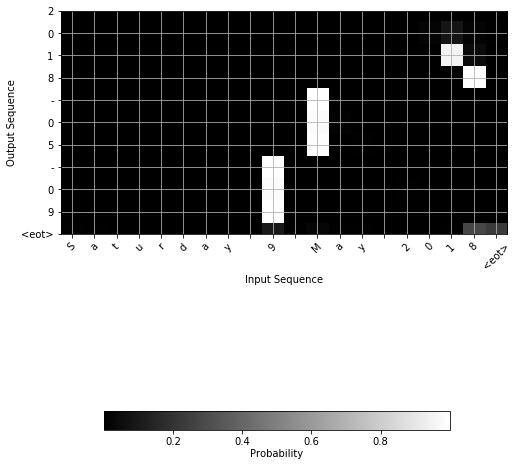

In [22]:
if __name__ == '__main__':
    args = ''
    args_exam = 'examples.txt';
    if args_exam.find('.txt') > 0:
        examples = load_examples(args_exam)
    else:
        examples = [args_exam]

    main(examples, args)